# Fine-tuning experiments

Based on the two notebooks : https://github.com/csho33/bacteria-ID/blob/master/1_reference_finetuning.ipynb & https://github.com/csho33/bacteria-ID/blob/master/3_clinical_finetuning.ipynb

In [60]:
from time import time
t00 = time()
import numpy as np
import os,sys,re
import random

## Loading the data

In [61]:
#Load from directory
os.chdir(os.getcwd())
base_dir = 'Raman_Data/'
als_dir = base_dir + 'ALS/'
ctrl_dir = base_dir + 'CTRL/'

base_dir2 = 'Bacteria_TL'
sys.path.append(base_dir2)

models = ['pretrained_model.ckpt', 'finetuned_model.ckpt', 'clinical_pretrained_model.ckpt']

In [62]:
all_files_als = os.listdir(als_dir)
all_files_als.sort(key=lambda f: int(re.sub('\D', '', f)))

all_files_ctrl = os.listdir(ctrl_dir)
all_files_ctrl.sort(key=lambda f: int(re.sub('\D', '', f)))

In [63]:
def parse_text(file, dir):
    with open(dir + file, 'rt') as fd:
        data=[]
        line = fd.readline()
        nline = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        data.append(nline)
        while line:
            line=fd.readline()
            nline = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            data.append(nline)
    return data

In [64]:
X=[] #actual y of spectra
Y=[] # 1 -> als; 0 -> ctrl
coord=[] #actual x of spectra

sep=[60,78,114,150,194,210,225,241,255,280,299,313,323,333,343,353,363,373,383,393] #Il manque le 227
groups=[] #for GROUP K FOLD
group=0
index=1
for f in all_files_als:
    data=[]
    datab=[]
    for e in parse_text(f, als_dir):
        if len(e) > 0:
            datab.append(float(e[0]))
            data.append(float(e[1]))
    coord.append(datab)
    X.append(data)
    Y.append(1)
    groups.append(group)
    if index in sep:
        group+=1
    index+=1
    
sep=[33,76,91,138,149,158,168,178,188,198]
index=1
for f in all_files_ctrl:
    data=[]
    datab=[]
    for e in parse_text(f, ctrl_dir):
        if len(e) > 0:
            datab.append(float(e[0]))
            data.append(float(e[1]))
    coord.append(datab)
    X.append(data)
    Y.append(0)
    groups.append(group)
    if index in sep:
        group+=1
    index+=1

In [65]:
X=np.array(X)
Y=np.array(Y)
groups=np.array(groups)
print(X.shape, Y.shape)

(591, 1174) (591,)


In [66]:
for i in range(len(X)):
    for j in range (len(X[i])):
        if(X[i][j] < 0):
            X[i][j] = 0

## Split our dataset into a finetunable set and a full test set

First, we decide to split our dataset into :
1) a "finetunable" set for finetune the pretrained model on our data

2) a "full test" set i.e the left over patients to test our resulting finetuned model

The split ratio is 2/3 -> 20 patients for finetune (12 ALS & 8 CTRL) and 10 for test (8 ALS & 2 CTRL). 

In [67]:
def split_dataset(num_als, num_ctrl):
    patient_idxs_finetune = []

    x = list(range(0, 20))
    patient_idxs_finetune = random.sample(x,num_als)
    patient_idxs_test = [i for i in x if i not in patient_idxs_finetune]

    x2 = list(range(20, 30))
    patient_idxs_finetune += random.sample(x2,num_ctrl)
    patient_idxs_test += [i for i in x2 if i not in patient_idxs_finetune]

    #Shuffle to avoid implicit leakage (1 the firsts and 0 the lasts)
    random.shuffle(patient_idxs_finetune)
    random.shuffle(patient_idxs_test)
    return patient_idxs_finetune, patient_idxs_test

In [68]:
#Some test to be sure
patient_idxs_finetune, patient_idxs_test = split_dataset(12, 8)
print(len(patient_idxs_finetune), patient_idxs_finetune)
print(len(patient_idxs_test), patient_idxs_test)

20 [15, 29, 9, 13, 6, 7, 2, 28, 10, 19, 12, 25, 1, 20, 22, 5, 24, 0, 27, 26]
10 [14, 16, 21, 11, 23, 4, 17, 3, 8, 18]


## Load ResNet

In [69]:
from resnet import ResNet
import os
import torch

In [70]:
# CNN parameters
batch_size=10
layers = 6
hidden_size = 100
block_size = 2
hidden_sizes = [hidden_size] * layers
num_blocks = [block_size] * layers
input_dim = 1174
in_channels = 64
n_classes = 2 # instead of 30, we use the 2 empiric groupings
os.environ['CUDA_VISIBLE_DEVICES'] = '{}'.format(0)
cuda = torch.cuda.is_available()

In [71]:
#Remove last layers
def removekey(d, listofkeys):
    r = dict(d)
    for key in listofkeys:
        print('key: {} is removed'.format(key))
        r.pop(key)
    return r

In [72]:
def load_model(n=0):
    cnn = ResNet(hidden_sizes, num_blocks, input_dim=input_dim,
                    in_channels=in_channels, n_classes=n_classes)
    if cuda: cnn.cuda()

    checkpoint = torch.load(base_dir2 + '/' + models[n], map_location=lambda storage, loc: storage)
    mod_weights = removekey(checkpoint, ['linear.weight', 'linear.bias'])
    cnn.load_state_dict(mod_weights, strict=False)
    return cnn, mod_weights, checkpoint

## Fine-tuning

### Custom Train/Val/Test split

Based on the "clinical" notebook we decide to implement a custom method of train/val/test split : the 20 patients are grouped into 4 sub-groups. The first 3 patients of each group are assigned to the training set, the 4th to the validation set and the 5th into the test set.

In [73]:
#20 patients into 4 groups of 5 patients
def group_patients(patient_idxs_finetune):
    patient_idxs = []
    x = patient_idxs_finetune
    for i in range(4):
        l = random.sample(x,5)
        patient_idxs.append(l)
        x = [i for i in x if i not in l]
    return patient_idxs

In [74]:
patient_idxs = group_patients(patient_idxs_finetune)

In [75]:
# Sample train/val/te spectra -> each group [train, train, train, val, test]
def custom_split_finetuning(patient_idxs):
    idx_tr, idx_val, idx_te = [], [], []
    for group_idx, patient_list in enumerate(patient_idxs):
        print('Group {} patients'.format(group_idx))
        print(' Tr: {}'.format(patient_list[:3]))
        print(' Val: {}'.format(patient_list[3]))
        print(' Te : {}'.format(patient_list[4]))
        for j, patient in enumerate(patient_list):
            l= np.where(groups == patient)
            start_idx = l[0][0]
            end_idx = l[0][len(l[0])-1]
            idx_range = list(range(start_idx, end_idx+1))
            np.random.shuffle(idx_range) #-> do we shuffle ? 
            print(patient, idx_range, len(idx_range))
            if j < 3:
                idx_tr.extend(idx_range)
            elif j ==3:
                idx_val.extend(idx_range)
            else:
                idx_te.extend(idx_range)
    return idx_tr, idx_val, idx_te

In [76]:
#Outputs len
idx_tr, idx_val, idx_te = custom_split_finetuning(patient_idxs)
print(len(idx_tr))
print(len(idx_val))
print(len(idx_te))

Group 0 patients
 Tr: [29, 1, 10]
 Val: 27
 Te : 25
29 [589, 582, 587, 585, 584, 588, 583, 581, 586, 590] 10
1 [70, 60, 64, 77, 73, 71, 72, 62, 74, 63, 69, 76, 67, 68, 75, 65, 61, 66] 18
10 [282, 294, 281, 293, 285, 291, 290, 298, 286, 289, 284, 287, 280, 296, 292, 288, 283, 297, 295] 19
27 [568, 562, 561, 564, 566, 563, 569, 570, 567, 565] 10
25 [545, 543, 544, 546, 549, 548, 550, 542, 547] 9
Group 1 patients
 Tr: [9, 7, 28]
 Val: 22
 Te : 19
9 [263, 261, 272, 275, 268, 262, 258, 266, 274, 273, 256, 276, 270, 257, 278, 259, 279, 260, 277, 269, 267, 265, 271, 264, 255] 25
7 [229, 236, 234, 238, 237, 233, 239, 228, 227, 240, 230, 225, 231, 232, 235, 226] 16
28 [572, 575, 571, 573, 574, 577, 579, 578, 580, 576] 10
22 [482, 474, 479, 480, 473, 476, 470, 477, 481, 478, 471, 469, 483, 475, 472] 15
19 [391, 392, 383, 390, 388, 387, 384, 385, 386, 389] 10
Group 2 patients
 Tr: [12, 6, 13]
 Val: 20
 Te : 15
12 [316, 319, 315, 321, 318, 317, 320, 322, 313, 314] 10
6 [224, 215, 218, 212, 214, 21

## Finetuning based on custom split

In [77]:
from datasets import spectral_dataloader
from training import run_epoch
from torch import optim

Finetune the cnn model with the train, val, test index splitted earlier on

In [78]:
# Fine-tune CNN
def finetune(cnn, idx_tr, idx_val, idx_te):
    epochs = 1
    batch_size = 10
    t0 = time()
    # Set up Adam optimizer
    optimizer = optim.Adam(cnn.parameters(), lr=1e-3, betas=(0.5, 0.999))
    # Set up dataloaders
    dl_tr = spectral_dataloader(X, Y, idxs=idx_tr,
        batch_size=batch_size, shuffle=True)
    dl_val = spectral_dataloader(X, Y, idxs=idx_val,
        batch_size=batch_size, shuffle=False)
    dl_te = spectral_dataloader(X, Y, idxs=idx_te,
        batch_size=batch_size, shuffle=False)
    # Fine-tune CNN for first fold
    best_val = 0
    no_improvement = 0
    max_no_improvement = 5
    print('Starting fine-tuning!')
    for epoch in range(epochs):
        print(' Epoch {}: {:0.2f}s'.format(epoch+1, time()-t0))
        # Train
        acc_tr, loss_tr = run_epoch(epoch, cnn, dl_tr, cuda,
            training=True, optimizer=optimizer)
        print('  Train acc: {:0.2f}'.format(acc_tr))
        # Val
        acc_val, loss_val = run_epoch(epoch, cnn, dl_val, cuda,
            training=False, optimizer=optimizer)
        print('  Val acc: {:0.2f}'.format(acc_val))
        # Test
        acc_te, loss_te = run_epoch(epoch, cnn, dl_te, cuda,
            training=False, optimizer=optimizer)
        print('  Test acc: {:0.2f}'.format(acc_te))
        # Check performance for early stopping
        if acc_val > best_val or epoch == 0:
            best_val = acc_val
            no_improvement = 0
        else:
            no_improvement += 1
        if no_improvement >= max_no_improvement:
            print('Finished after {} epochs!'.format(epoch+1))
            break
    print('Finished: {:0.2f}s'.format(time()-t0))

## Make predictions

In [79]:
from training import get_predictions
from scipy import stats
from statistics import mean

Get the test indices for testing the model based on the patient IDs

In [80]:
#1/ Getting test indices
def get_test_indices(patient_idxs_test):
    idx_te = []
    for group_idx in patient_idxs_test:
        l= np.where(groups == group_idx)
        start_idx = l[0][0]
        end_idx = l[0][len(l[0])-1]
        idx_te += list(range(start_idx, end_idx+1))
    return idx_te

Predict on cnn with index test resulting from the method above

In [81]:
def predict(cnn, idx_te):
    #1/ Predicting on finetuned model
    dl_te = spectral_dataloader(X, Y, idxs=idx_te,
        batch_size=batch_size, shuffle=False)
    #t0 = time()
    y_hat = get_predictions(cnn, dl_te, cuda)
    #print('Finished: {:0.2f}s'.format(time()-t0))
    #2/ Getting the right Y indices for comparing
    Y_l = []
    for i in range(len(Y)):
        if i in idx_te:
            Y_l.append(Y[i])
    #3/ Computing accuracy and std
    acc = (y_hat == Y_l).mean()
    print('Accuracy: {:0.1f}%'.format(100*acc))
    return acc, Y_l, y_hat

## Get average accuracy and std on finetuned models

Combine functions to have the average accuracy on 10 tests

In [87]:
def results(num_model, idx_tr, idx_val, idx_te, fn_idx_te):
    list_acc=[]
    #Average on 10 times
    for i in range(10):
        print(i+1)
        #Load model
        cnn, _, _ = load_model(num_model)
        #finetune it owith custom split
        finetune(cnn, idx_tr, idx_val, idx_te)
        #get accuracy to make an average and std on test set
        list_acc.append(predict(cnn, fn_idx_te)[0])
    return list_acc

## Trials :

Distribution of 12 ALS & 8 CTRL :

In [88]:
num_als=12
num_ctrl = 8
patient_idxs_finetune, patient_idxs_test = split_dataset(num_als, num_ctrl)
patient_idxs = group_patients(patient_idxs_finetune)
idx_tr, idx_val, idx_te = custom_split_finetuning(patient_idxs)

Group 0 patients
 Tr: [19, 2, 26]
 Val: 23
 Te : 24
19 [389, 391, 390, 385, 392, 386, 383, 388, 384, 387] 10
2 [88, 110, 83, 97, 96, 90, 111, 91, 104, 99, 92, 105, 86, 85, 98, 102, 103, 109, 87, 81, 79, 100, 82, 113, 112, 93, 80, 95, 106, 89, 84, 101, 107, 78, 94, 108] 36
26 [557, 558, 553, 551, 559, 560, 556, 552, 554, 555] 10
23 [524, 486, 517, 487, 529, 488, 502, 507, 503, 508, 500, 515, 528, 504, 493, 525, 489, 514, 510, 526, 499, 492, 501, 522, 491, 497, 484, 519, 505, 530, 511, 516, 496, 520, 521, 513, 523, 518, 506, 490, 485, 495, 494, 498, 509, 527, 512] 47
24 [540, 537, 535, 536, 539, 541, 534, 533, 532, 538, 531] 11
Group 1 patients
 Tr: [11, 12, 16]
 Val: 15
 Te : 10
11 [308, 304, 305, 303, 299, 307, 302, 310, 301, 312, 309, 311, 306, 300] 14
12 [321, 317, 320, 316, 322, 318, 314, 313, 315, 319] 10
16 [355, 354, 353, 359, 361, 362, 356, 358, 360, 357] 10
15 [347, 350, 351, 343, 346, 344, 348, 352, 349, 345] 10
10 [282, 284, 296, 285, 280, 294, 298, 287, 297, 283, 291, 286, 2

In [89]:
n1 = len([i for i in idx_tr if i < 393])
n2 = len([i for i in idx_val if i < 393])
n3 = len([i for i in idx_te if i < 393])
print("Number of samples to train the finetune model : ", len(idx_tr), " -> ALS : ", n1, ", CTRL : ", len(idx_tr)-n1)
print("Number of samples to validate the finetune model : ", len(idx_val), " -> ALS : ", n2, ", CTRL : ", len(idx_val)-n2)
print("Number of samples to test the finetune model : ", len(idx_te), " -> ALS : ", n3, ", CTRL : ", len(idx_te)-n3)

Number of samples to train the finetune model :  225  -> ALS :  147 , CTRL :  78
Number of samples to validate the finetune model :  77  -> ALS :  20 , CTRL :  57
Number of samples to test the finetune model :  53  -> ALS :  33 , CTRL :  20


In [90]:
fn_idx_te = get_test_indices(patient_idxs_test)
m= len([i for i in fn_idx_te if i < 393])
print("Number of samples to test : ", len(fn_idx_te), " -> ALS : ", m, ", CTRL : ", len(fn_idx_te)-m)

Number of samples to test :  236  -> ALS :  193 , CTRL :  43


- pretrained_model :

In [91]:
list_acc = results(0, idx_tr, idx_val, idx_te, fn_idx_te)
print(mean(list_acc))
print(np.std(list_acc))

1
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 86.67
  Val acc: 45.45
  Test acc: 77.36
Finished: 7.28s
Accuracy: 81.4%
2
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 82.22
  Val acc: 92.21
  Test acc: 79.25
Finished: 7.10s
Accuracy: 66.5%
3
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 86.67
  Val acc: 88.31
  Test acc: 79.25
Finished: 7.05s
Accuracy: 74.2%
4
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 84.44
  Val acc: 81.82
  Test acc: 77.36
Finished: 7.08s
Accuracy: 78.4%
5
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 88.44
  Val acc: 89.61
  Test acc: 79.25
Finished: 7.12s
Accuracy: 72.0%
6
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning

- finetuned_model :

In [92]:
list_acc = results(1, idx_tr, idx_val, idx_te, fn_idx_te)
print(mean(list_acc))
print(np.std(list_acc))

1
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 85.33
  Val acc: 97.40
  Test acc: 79.25
Finished: 7.08s
Accuracy: 66.1%
2
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 86.67
  Val acc: 44.16
  Test acc: 75.47
Finished: 7.24s
Accuracy: 80.5%
3
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 89.33
  Val acc: 90.91
  Test acc: 77.36
Finished: 7.12s
Accuracy: 75.8%
4
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 84.89
  Val acc: 97.40
  Test acc: 75.47
Finished: 7.05s
Accuracy: 66.1%
5
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 87.56
  Val acc: 93.51
  Test acc: 79.25
Finished: 7.09s
Accuracy: 71.6%
6
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning

- clinical_pretrained_model

In [93]:
list_acc = results(2, idx_tr, idx_val, idx_te, fn_idx_te)
print(mean(list_acc))
print(np.std(list_acc))

1
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 88.00
  Val acc: 90.91
  Test acc: 81.13
Finished: 7.11s
Accuracy: 70.3%
2
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 88.00
  Val acc: 96.10
  Test acc: 81.13
Finished: 7.04s
Accuracy: 67.8%
3
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 86.22
  Val acc: 94.81
  Test acc: 81.13
Finished: 7.10s
Accuracy: 67.4%
4
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 85.78
  Val acc: 94.81
  Test acc: 81.13
Finished: 7.09s
Accuracy: 66.5%
5
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 86.22
  Val acc: 84.42
  Test acc: 81.13
Finished: 7.09s
Accuracy: 71.6%
6
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning

Distribution of 15 ALS & 5 CTRL

In [103]:
num_als=15
num_ctrl = 5
patient_idxs_finetune, patient_idxs_test = split_dataset(num_als, num_ctrl)
patient_idxs = group_patients(patient_idxs_finetune)
idx_tr, idx_val, idx_te = custom_split_finetuning(patient_idxs)

Group 0 patients
 Tr: [13, 0, 22]
 Val: 1
 Te : 12
13 [325, 324, 326, 332, 323, 329, 328, 327, 331, 330] 10
0 [35, 57, 28, 19, 31, 22, 34, 48, 15, 6, 41, 20, 7, 36, 58, 12, 16, 32, 53, 0, 27, 46, 17, 13, 45, 21, 26, 43, 44, 4, 23, 39, 14, 56, 47, 37, 5, 49, 9, 51, 11, 55, 59, 40, 50, 1, 54, 25, 38, 10, 2, 18, 33, 52, 3, 29, 42, 24, 8, 30] 60
22 [470, 471, 475, 479, 476, 473, 474, 478, 477, 481, 469, 483, 472, 480, 482] 15
1 [73, 69, 67, 60, 75, 71, 62, 76, 64, 74, 63, 68, 77, 66, 72, 61, 70, 65] 18
12 [322, 321, 314, 316, 319, 318, 320, 315, 313, 317] 10
Group 1 patients
 Tr: [28, 29, 10]
 Val: 11
 Te : 26
28 [577, 574, 576, 578, 572, 580, 579, 573, 571, 575] 10
29 [583, 588, 584, 585, 586, 587, 582, 590, 589, 581] 10
10 [293, 292, 289, 281, 297, 295, 286, 285, 291, 282, 296, 283, 287, 294, 284, 290, 280, 288, 298] 19
11 [312, 300, 303, 305, 309, 301, 308, 299, 306, 302, 307, 310, 304, 311] 14
26 [559, 556, 558, 551, 555, 552, 553, 557, 560, 554] 10
Group 2 patients
 Tr: [14, 8, 7]
 Va

In [104]:
n1 = len([i for i in idx_tr if i < 393])
n2 = len([i for i in idx_val if i < 393])
n3 = len([i for i in idx_te if i < 393])
print("Number of samples to train the finetune model : ", len(idx_tr), " -> ALS : ", n1, ", CTRL : ", len(idx_tr)-n1)
print("Number of samples to validate the finetune model : ", len(idx_val), " -> ALS : ", n2, ", CTRL : ", len(idx_val)-n2)
print("Number of samples to test the finetune model : ", len(idx_te), " -> ALS : ", n3, ", CTRL : ", len(idx_te)-n3)

Number of samples to train the finetune model :  194  -> ALS :  159 , CTRL :  35
Number of samples to validate the finetune model :  73  -> ALS :  73 , CTRL :  0
Number of samples to test the finetune model :  39  -> ALS :  20 , CTRL :  19


In [96]:
fn_idx_te = get_test_indices(patient_idxs_test)
m= len([i for i in fn_idx_te if i < 393])
print("Number of samples to test : ", len(fn_idx_te), " -> ALS : ", m, ", CTRL : ", len(fn_idx_te)-m)

Number of samples to test :  195  -> ALS :  76 , CTRL :  119


In [98]:
list_acc = results(1, idx_tr, idx_val, idx_te, fn_idx_te)
print(mean(list_acc))
print(np.std(list_acc))

1
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 88.80
  Val acc: 79.17
  Test acc: 41.89
Finished: 7.34s
Accuracy: 39.0%
2
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 92.00
  Val acc: 79.17
  Test acc: 43.24
Finished: 7.15s
Accuracy: 39.0%
3
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 91.20
  Val acc: 81.94
  Test acc: 48.65
Finished: 7.21s
Accuracy: 45.1%
4
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 92.80
  Val acc: 79.17
  Test acc: 41.89
Finished: 7.36s
Accuracy: 39.5%
5
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 89.20
  Val acc: 79.17
  Test acc: 52.70
Finished: 7.12s
Accuracy: 42.1%
6
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning

## Plot confusion matrix of best model

In [99]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
num_als=13
num_ctrl = 7
patient_idxs_finetune, patient_idxs_test = split_dataset(num_als, num_ctrl)
patient_idxs = group_patients(patient_idxs_finetune)
idx_tr, idx_val, idx_te = custom_split_finetuning(patient_idxs)#Load model
cnn, _, _ = load_model(1)
#finetune it owith custom split
finetune(cnn, idx_tr, idx_val, idx_te)
acc, y, y_hat = predict(cnn, fn_idx_te)

Group 0 patients
 Tr: [13, 4, 9]
 Val: 7
 Te : 26
13 [328, 323, 329, 327, 331, 330, 325, 326, 324, 332] 10
4 [176, 154, 169, 156, 157, 163, 170, 160, 177, 174, 162, 173, 178, 166, 168, 187, 164, 161, 184, 152, 181, 172, 175, 180, 189, 186, 153, 193, 185, 167, 179, 182, 155, 151, 171, 159, 192, 191, 183, 188, 150, 190, 158, 165] 44
9 [266, 278, 273, 262, 255, 276, 267, 264, 257, 263, 275, 259, 268, 261, 272, 260, 258, 270, 271, 269, 274, 256, 265, 279, 277] 25
7 [230, 231, 226, 232, 238, 234, 233, 240, 239, 225, 236, 229, 227, 237, 228, 235] 16
26 [553, 551, 558, 555, 557, 560, 556, 559, 552, 554] 10
Group 1 patients
 Tr: [22, 1, 21]
 Val: 8
 Te : 25
22 [474, 477, 472, 470, 482, 471, 480, 483, 479, 475, 481, 469, 478, 473, 476] 15
1 [70, 75, 63, 77, 62, 66, 68, 67, 61, 65, 64, 76, 72, 73, 60, 71, 69, 74] 18
21 [457, 460, 454, 452, 434, 443, 467, 438, 461, 462, 456, 463, 442, 446, 433, 432, 447, 468, 428, 440, 427, 458, 466, 444, 459, 464, 426, 445, 439, 453, 431, 449, 441, 451, 448, 437

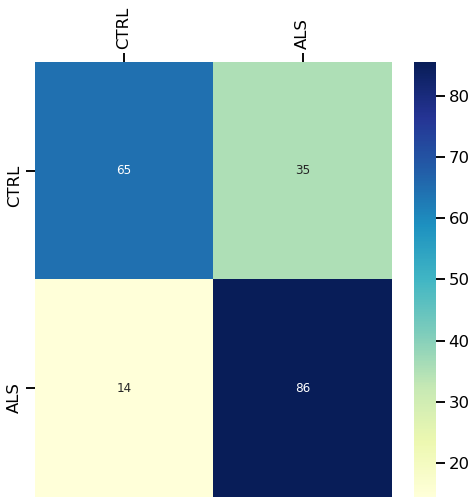

In [106]:
# Plot confusion matrix
sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = ["CTRL", "ALS"]
cm = confusion_matrix(y, y_hat, labels=[0, 1])
plt.figure(figsize=(8, 8))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()

## Some comments

The accuracy is corely correlated to the number of samples -> unbalanced data 

If the model is finetuned with a lot of ALS samples it will be bad to predict on CTRL data ! (the inverse is rare/ impossible due to unbalancement !)

We could have created a custom split on the number of samples but the effort would have been useless regarding the fact that we have to keep samples per patients and the number is highly variable -> 70 >> 9